In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 
from scipy.stats import shapiro
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, MeanShift
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [13]:
data = pd.read_csv('./input_data/penguins_lter.csv')
data = data.drop(['Species', 'studyName', 'Sample Number', 'Individual ID', 'Comments', 'Stage', 'Region'], axis=1)
data.head()

,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Torgersen,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN
1,Torgersen,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454
2,Torgersen,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302
3,Torgersen,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Torgersen,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426


In [14]:
data['Date Egg'] =  pd.to_datetime(data['Date Egg'], format='%m/%d/%y')
data['Date Egg'] = pd.DatetimeIndex(data['Date Egg']).month
data = data.rename(columns={'Date Egg': 'MonthEgg', "Clutch Completion": "ClutchCompletion", 
                            "Culmen Length (mm)": "CulmenLength", "Culmen Depth (mm)": "CulmenDepth", 
                            "Flipper Length (mm)": "FlipperLength", "Body Mass (g)": "BodyMass", 
                            "Delta 15 N (o/oo)": "Delta15N", "Delta 13 C (o/oo)": "Delta13C"})

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Island            344 non-null    object 
 1   ClutchCompletion  344 non-null    object 
 2   MonthEgg          344 non-null    int64  
 3   CulmenLength      342 non-null    float64
 4   CulmenDepth       342 non-null    float64
 5   FlipperLength     342 non-null    float64
 6   BodyMass          342 non-null    float64
 7   Sex               334 non-null    object 
 8   Delta15N          330 non-null    float64
 9   Delta13C          331 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 27.0+ KB


In [16]:
data = data[data.Sex != '.']
data.Sex.replace(to_replace=dict(FEMALE=1, MALE=0), inplace=True)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 1 to 343
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Island            324 non-null    object 
 1   ClutchCompletion  324 non-null    object 
 2   MonthEgg          324 non-null    int64  
 3   CulmenLength      324 non-null    float64
 4   CulmenDepth       324 non-null    float64
 5   FlipperLength     324 non-null    float64
 6   BodyMass          324 non-null    float64
 7   Sex               324 non-null    float64
 8   Delta15N          324 non-null    float64
 9   Delta13C          324 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 27.8+ KB


In [17]:
encoder = OrdinalEncoder()
data[['Island', 'ClutchCompletion']] = encoder.fit_transform(data[['Island', 'ClutchCompletion']])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 1 to 343
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Island            324 non-null    float64
 1   ClutchCompletion  324 non-null    float64
 2   MonthEgg          324 non-null    int64  
 3   CulmenLength      324 non-null    float64
 4   CulmenDepth       324 non-null    float64
 5   FlipperLength     324 non-null    float64
 6   BodyMass          324 non-null    float64
 7   Sex               324 non-null    float64
 8   Delta15N          324 non-null    float64
 9   Delta13C          324 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 27.8 KB


In [18]:
data.head()

,Island,ClutchCompletion,MonthEgg,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Sex,Delta15N,Delta13C
1,2.0,1.0,11,39.5,17.4,186.0,3800.0,1.0,8.94956,-24.69454
2,2.0,1.0,11,40.3,18.0,195.0,3250.0,1.0,8.36821,-25.33302
4,2.0,1.0,11,36.7,19.3,193.0,3450.0,1.0,8.76651,-25.32426
5,2.0,1.0,11,39.3,20.6,190.0,3650.0,0.0,8.66496,-25.29805
6,2.0,0.0,11,38.9,17.8,181.0,3625.0,1.0,9.18718,-25.21799


In [19]:
scaler = MinMaxScaler()
columns = ['Island', 'ClutchCompletion', 'MonthEgg', 'CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass', 'Delta15N', 'Delta13C']
data[columns] = scaler.fit_transform(data[columns])

In [20]:
data.describe()

,Island,ClutchCompletion,MonthEgg,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Sex,Delta15N,Delta13C
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,0.316358,0.895062,0.033951,0.434669,0.479461,0.495187,0.420546,0.503086,0.462864,0.425093
std,0.353327,0.306948,0.181382,0.199296,0.234213,0.236588,0.224799,0.500764,0.230680,0.252796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.269091,0.294643,0.305085,0.236111,0.000000,0.280891,0.221125
50%,0.250000,1.000000,0.000000,0.467273,0.500000,0.423729,0.375000,1.000000,0.428868,0.375839
75%,0.500000,1.000000,0.000000,0.603636,0.654762,0.694915,0.583333,1.000000,0.647356,0.627473
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 1 to 343
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Island            324 non-null    float64
 1   ClutchCompletion  324 non-null    float64
 2   MonthEgg          324 non-null    float64
 3   CulmenLength      324 non-null    float64
 4   CulmenDepth       324 non-null    float64
 5   FlipperLength     324 non-null    float64
 6   BodyMass          324 non-null    float64
 7   Sex               324 non-null    float64
 8   Delta15N          324 non-null    float64
 9   Delta13C          324 non-null    float64
dtypes: float64(10)
memory usage: 27.8 KB


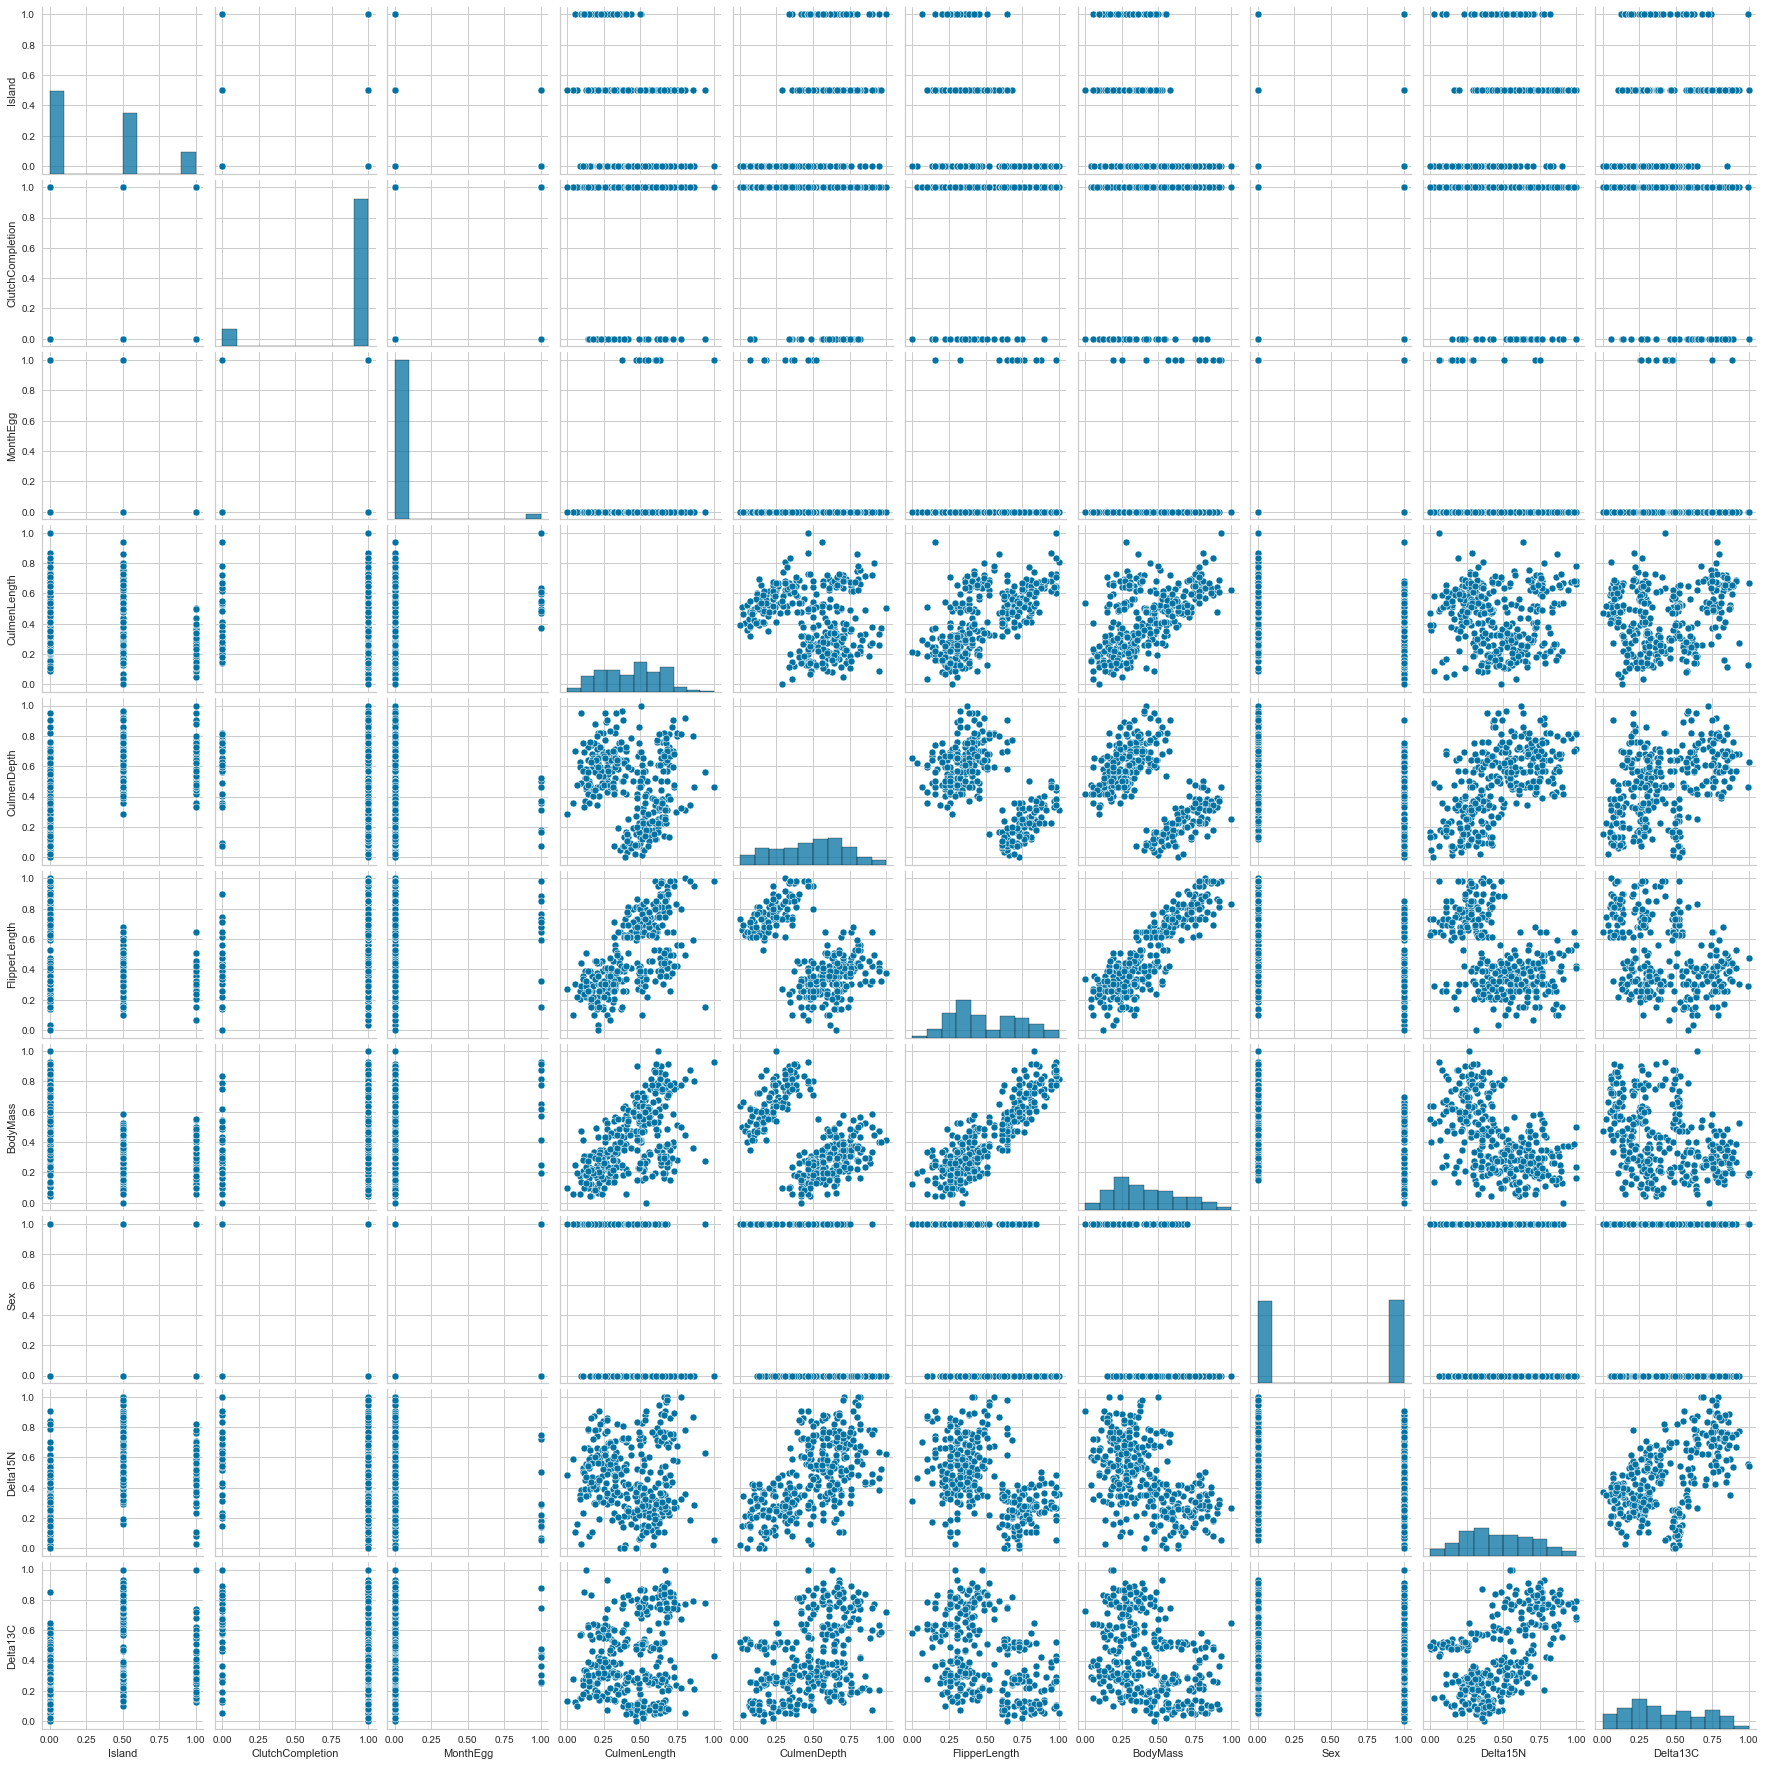

In [22]:
sns.pairplot(data)

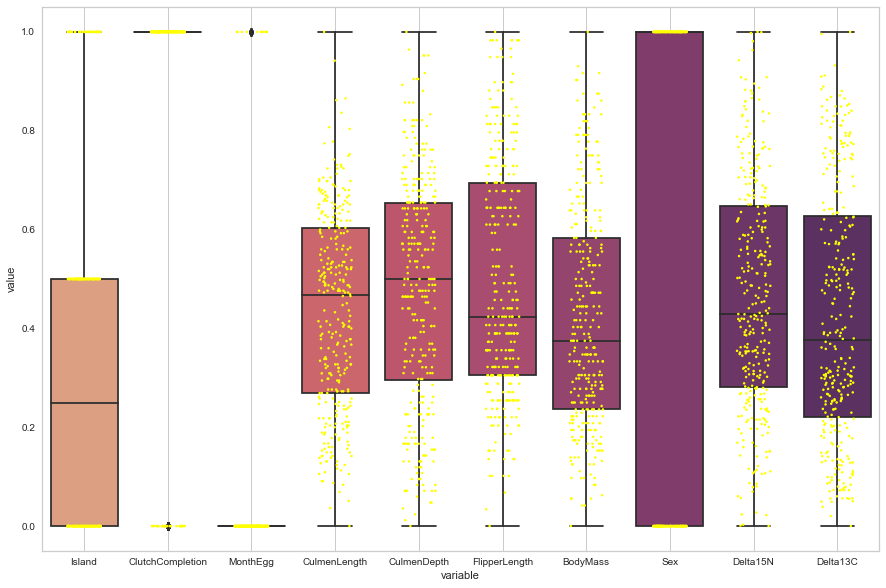

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(x='variable', y='value', data=pd.melt(data), palette='flare')
sns.stripplot(x='variable', y='value', data=pd.melt(data), color='yellow', jitter=0.2, size=2.5)
plt.grid()

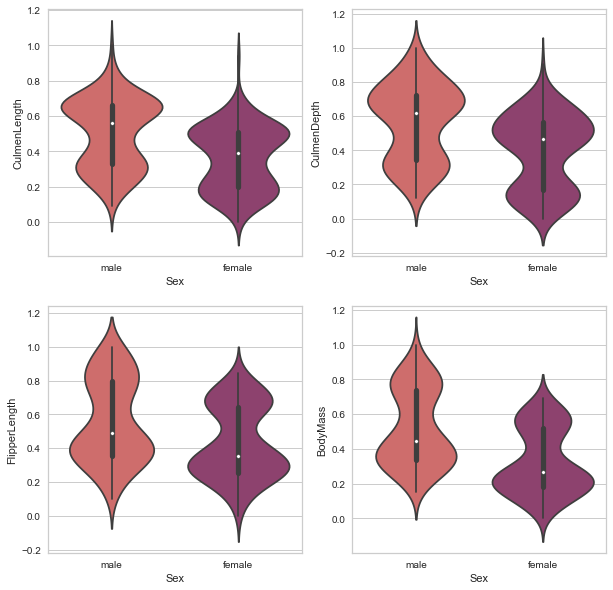

In [26]:
violin_columns = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
i = 1 
plt.figure(figsize=(10, 10))
for col in violin_columns:
    plt.subplot(2, 2, i)
    fig2 = sns.violinplot(x=data['Sex'], y=data[col], palette='flare')
    fig2.set_xticklabels(['male', 'female'])
    i += 1
plt.show()

<AxesSubplot:>

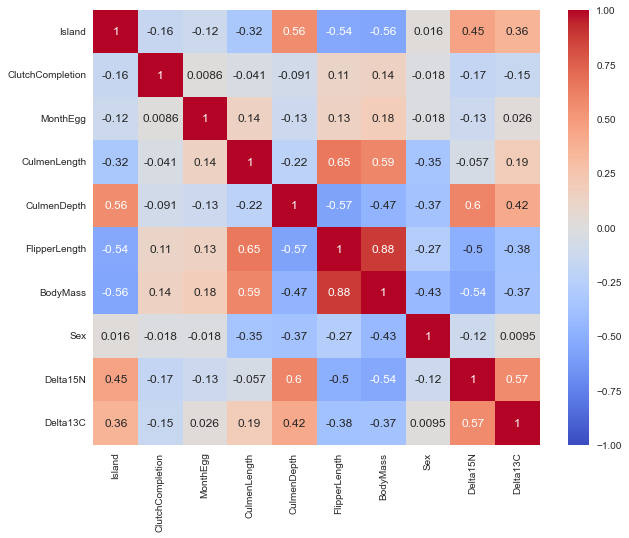

In [27]:
correlations = data.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, vmin=-1, cmap='coolwarm', annot=True)

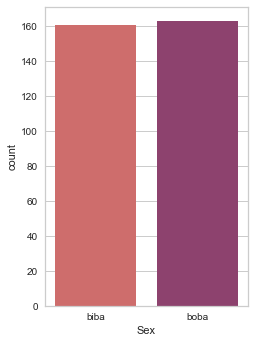

In [29]:
plt.subplot(1, 2, 1)
fig1 = sns.countplot(data=data, x="Sex", palette='flare')
fig1.set_xticklabels(['biba', 'boba'])
plt.show()

<AxesSubplot:xlabel='FlipperLength', ylabel='BodyMass'>

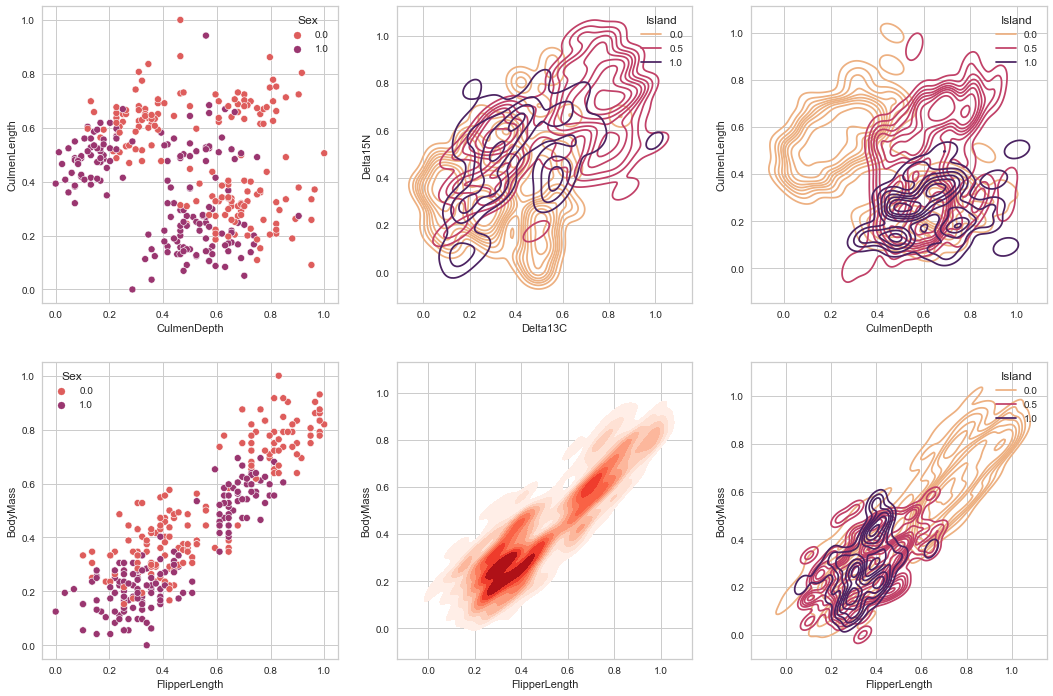

In [30]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x=data['CulmenDepth'], y=data['CulmenLength'], hue=data['Sex'], palette='flare')

plt.subplot(2, 3, 2)
sns.kdeplot(x=data.Delta13C, y=data.Delta15N, hue=data['Island'], shade=False, bw_adjust=.5, palette='flare')

plt.subplot(2, 3, 3)
sns.kdeplot(x=data['CulmenDepth'], y=data['CulmenLength'], hue=data['Island'], shade=False, bw_adjust=.5, palette='flare')

plt.subplot(2, 3, 4)
sns.scatterplot(x=data['FlipperLength'], y=data['BodyMass'], hue=data['Sex'], palette='flare')

plt.subplot(2, 3, 5)
sns.kdeplot(x=data['FlipperLength'], y=data['BodyMass'], cmap='Reds', shade=True, bw_adjust=.5, palette='flare')

plt.subplot(2, 3, 6)
sns.kdeplot(x=data['FlipperLength'], y=data['BodyMass'], hue=data['Island'], shade=False, bw_adjust=.5, palette='flare')

<AxesSubplot:xlabel='Delta13C', ylabel='Delta15N'>

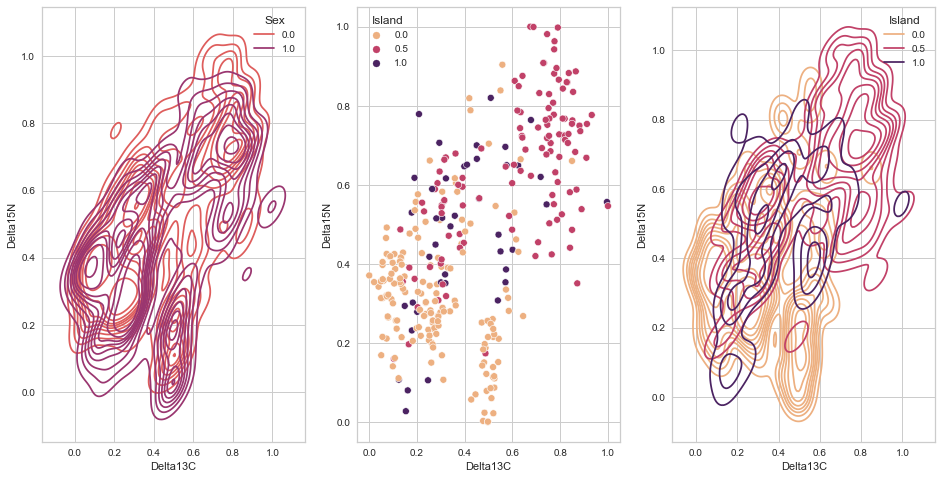

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
sns.kdeplot(x=data.Delta13C, y=data.Delta15N, hue=data['Sex'], shade=False, bw_adjust=.5, palette='flare')

plt.subplot(1, 3, 2)
sns.scatterplot(x=data['Delta13C'], y=data['Delta15N'], hue=data['Island'], palette='flare')

plt.subplot(1, 3, 3)
sns.kdeplot(x=data.Delta13C, y= data.Delta15N, hue=data['Island'], shade=False, bw_adjust=.5, palette='flare')

<AxesSubplot:title={'center':'D13C, D15N and BodyMass colored by Sex'}, xlabel='Delta13C', ylabel='Delta15N'>

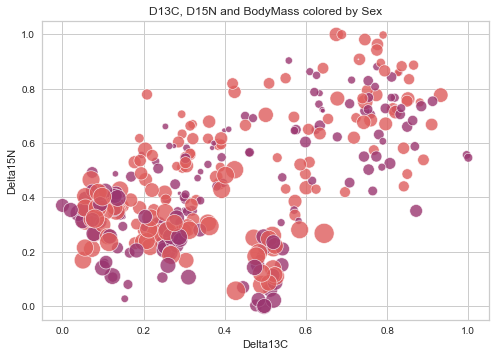

In [32]:
plt.title('D13C, D15N and BodyMass colored by Sex')
sns.scatterplot(data=data, x='Delta13C', y='Delta15N', 
                size='BodyMass', hue="Sex", legend=False, 
                sizes=(1, 400), alpha=0.8, palette='flare')

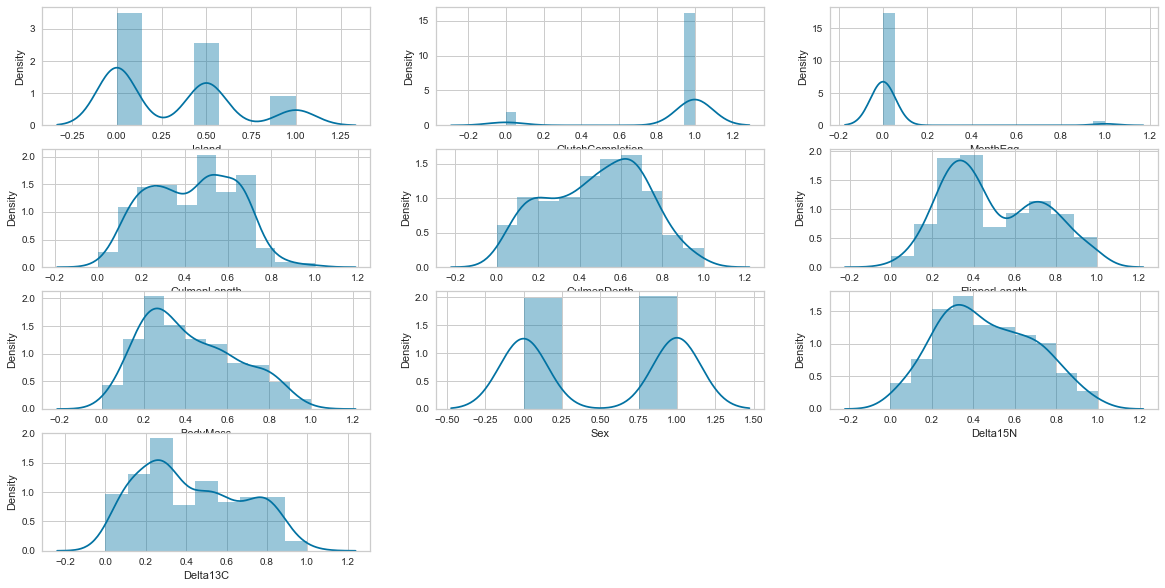

In [34]:
from warnings import filterwarnings
filterwarnings('ignore')

a=1
plt.figure(figsize=(20, 10))

for i in data.columns:
    plt.subplot(4, 3, a)
    sns.distplot(data[i])
    a += 1
    
plt.show()